# Applied Data Science (MAST30034) Tutorial 2

### Tutorial 2  Content
`pyspark`:
- _Under the hood - lazy evaluation_
- Basic transformation functions
- Spark SQL (Optional)

`geopandas`:
- Installation
- Shapefiles
- Spark User Defined Functions (UDF)

New Visualizations and Basic Analysis:
- `folium`
- Choropleths
- A revision of Pearson Correlation
- Feature Engineering

You may use any visualization taught in previous subjects for your Project (assumed knowledge).
_________________

## Transformations and Immutability
Transformations in PySpark will transform a Spark DataFrame into a new DataFrame without altering the original data. This means that Spark is **immutable** (i.e there is no `inplace=True` argument like some `pandas` methods).

For example, operations will return transformed results rather than mutating the original. Therefore, it is quite common to see:
```python
sdf = sdf.withColumn(
    'int_col',
    F.col('str_numerical_col').cast('INT')
)
```


## Lazy Evaluation at the High Level
Spark operations are evaluated lazily. This is because there is a driver under-the-hood which optimizes and makes your operations more efficient. This means that your data does not "move" until called upon. Let's explore how this works at the high-level.

### DAG (Directed Acyclic Graph)
For those who have not taken 2nd year algorithms, a DAG is a graph where there are "no loops". That is, one can only traverse forward and never backwards. This is especially useful (in this context) with representing a job or processes. For example:

![dag](https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2Fmichal.karzynski.pl%2Fimages%2Fillustrations%2F2017-03-19%2Fairflow-example-dag.png&f=1&nofb=1)

Here, we have a DAG generated by Apache Airflow which manages a certain job. From left to right, things are run in order. 

### Spark, DAGs, and Lazy Evaluation 
Specifically for Spark, transformations are added to a DAG in a similar to the above example. Whenever the Spark driver requests data (i.e writing, using `.collect()`, etc), the DAG gets executed. This means that until we need to **physicalize** the data, no code is run at all.

Why is this good? The major advantage is that Spark makes several code optimizations under-the-hood by looking at the whole DAG each time you add a step. This is the same for SQL Engines which will run query optimizations before being executed. For any in-built transformation or function, Spark will optimize the efficiency by reordering the steps or taking shortcuts to simplify several steps. This is not possible if the data is physicalized each time you run it like `pandas`. 


Example:
- You execute every transformation like `pandas`.
- This means you must physicalize every intermediate step into memory. Whilst this can be fast, you are limited by the memory (RAM). 
- When you take into account the costs of RAM over time (especially if this is an ETL pipeline that you run daily), this is not cost efficient. 
- Why does this matter? Well, it actually does because you are never really interested in the intermediate transformation steps when running a production pipeline, only the end result.
- As such, your job when writing Spark is to tell just tell Spark the overall process and let it figure it out lol.
- Yes, we know some of you like to figure things out under-the-hood, you may investigate it in your own time. For now, just getting things to work is the baseline!


General Rules:
- Always use built-in functions and methods where possible. This is because Spark is designed to optimize code that it understands.
- When applying a custom user function known as a **User Defined Function** (UDF), Spark does not understand the function code. This means it is is black box and will eat up resources and time.
- Never use `.collect()` if possible, aim to plan your code out and only physicalize your data when required. 
- Save "checkpoints" for your dataset. If you have applied a few transformations and are happy with this intermediate step, save it. That way, you don't need to keep rerunning your code every time you need the data.


### Lazy Evaluation in applications
Lazy evaluation is also extensively used in many other applications. Python natively have generator/yield as a way to implement lazy evaluation. TensorFlow, a popular tensor computing library also implements lazy evaluation via [computation graphs](https://d3lm.medium.com/understand-tensorflow-by-mimicking-its-api-from-scratch-faa55787170d) (DAG).

<img src="../../media/tensorflow_lazyeval.png" alt-text="computation graph" width=800px>

Here are some examples of Lazy Evaluation:
- As a Data Scientist, this really only occurs under-the-hood with the `ML` libraries you import.
- As a Data Engineer, this is very common with `node` related Graph Databases such as `Neo4J`.

Essentially, this happens under-the-hood for a lot of `python` libraries that you use, notably, Spark.

In [1]:
import time

In [2]:
def create_object(n=4):
    """
    A function to create `n` number of objects
    using a naive method.
    :param n: number of elements (default 4)
    """
    obj = []
    for i in range(n):
        obj.append(time.sleep(i))
    return obj


def create_object_lazy(n=4):
    """
    A function to create `n` number of objects
    using lazy evaluation.
    :param n: number of elements (default 4)
    """
    for i in range(n):
        yield time.sleep(i)
        

def execute_action(obj, n=3):
    """
    A function that iterates an object for `n` number of times.
    :param n: number of iterations (default 3)
    """
    obj = iter(obj)
    for i in range(n):
        next(obj)
        # Do some action
        pass

In [3]:
# This object takes 6 seconds to create
%time eager = create_object()
# Executed immediately, total time: 6 sec
%time execute_action(eager)

# This object is created immediately
%time lazy = create_object_lazy()
# Takes 3 sec to execute, total time: 3 sec
%time execute_action(lazy)

CPU times: user 589 µs, sys: 1.54 ms, total: 2.13 ms
Wall time: 6.01 s
CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 9.78 µs
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
CPU times: user 777 µs, sys: 346 µs, total: 1.12 ms
Wall time: 3 s


## Reading in a Directory of Parquets
In Spark, you can read in a directory of parquet files (or partitions, feel free to Google or Chat-GPT this up) rather than reading it one-by-one and concatenating them. 

Just note that all the data types **must** align, otherwise you will run into an error.

In [4]:
from pyspark.sql import SparkSession, functions as F

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Tutorial 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

24/08/09 09:20:10 WARN Utils: Your hostname, MacBook-Air-cua-Vu.local resolves to a loopback address: 127.0.0.1; using 10.12.25.14 instead (on interface en0)
24/08/09 09:20:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/09 09:20:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


24/08/09 09:20:22 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [5]:
sdf = spark.read.parquet('../../data/tlc_data/')
sdf.show(1, vertical=True, truncate=100)

-RECORD 0------------------------------------
 VendorID              | 2                   
 tpep_pickup_datetime  | 2024-01-01 00:57:55 
 tpep_dropoff_datetime | 2024-01-01 01:17:43 
 passenger_count       | 1                   
 trip_distance         | 1.72                
 RatecodeID            | 1                   
 store_and_fwd_flag    | N                   
 PULocationID          | 186                 
 DOLocationID          | 79                  
 payment_type          | 2                   
 fare_amount           | 17.7                
 extra                 | 1.0                 
 mta_tax               | 0.5                 
 tip_amount            | 0.0                 
 tolls_amount          | 0.0                 
 improvement_surcharge | 1.0                 
 total_amount          | 22.7                
 congestion_surcharge  | 2.5                 
 Airport_fee           | 0.0                 
only showing top 1 row



Notice how there is an error:
- `Parquet column cannot be converted in file` (_this column could not be converted_)
- `Column: [VendorID], Expected: bigint, Found: INT32` (_we expected bigint data type, but got an integer data type_)

How awesome is it to be able to read errors properly. Learn to read the messages before searching or asking for help.

In [7]:
sdf_jan = spark.read.parquet('../../data/tlc_data/2024-01.parquet')
sdf_jan.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [8]:
sdf_feb = spark.read.parquet('../../data/tlc_data/2024-02.parquet')
sdf_feb.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



In [9]:
sdf_mar = spark.read.parquet('../../data/tlc_data/2024-03.parquet')
sdf_mar.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



If you have gone through the Data Dictionary, you would know that `VendorID` is an `int` field with values `1` and `2`, therefore, it does not make sense to have it as a `long` type.

In [10]:
sdf_feb.schema

StructType([StructField('VendorID', IntegerType(), True), StructField('tpep_pickup_datetime', TimestampNTZType(), True), StructField('tpep_dropoff_datetime', TimestampNTZType(), True), StructField('passenger_count', LongType(), True), StructField('trip_distance', DoubleType(), True), StructField('RatecodeID', LongType(), True), StructField('store_and_fwd_flag', StringType(), True), StructField('PULocationID', IntegerType(), True), StructField('DOLocationID', IntegerType(), True), StructField('payment_type', LongType(), True), StructField('fare_amount', DoubleType(), True), StructField('extra', DoubleType(), True), StructField('mta_tax', DoubleType(), True), StructField('tip_amount', DoubleType(), True), StructField('tolls_amount', DoubleType(), True), StructField('improvement_surcharge', DoubleType(), True), StructField('total_amount', DoubleType(), True), StructField('congestion_surcharge', DoubleType(), True), StructField('Airport_fee', DoubleType(), True)])

What we are going to do **is adhere to best practices in industry**. That is, we will define and fix our schemas _before_ we read the data in. This is to prevent upstream sources from changing data types and breaking everything.

1. Ensure consistent casing
2. Ensure all columns exist

In [11]:
# now, we want to ensure everything has consistent casing to make our lives easier
consistent_col_casing = [F.col(col_name).alias(col_name.lower()) for col_name in sdf_feb.columns]
sdf_feb = sdf_feb.select(*consistent_col_casing)

# this will be used in the cell below when reading in
sdf_schema = sdf_feb.schema
sdf_schema

StructType([StructField('vendorid', IntegerType(), True), StructField('tpep_pickup_datetime', TimestampNTZType(), True), StructField('tpep_dropoff_datetime', TimestampNTZType(), True), StructField('passenger_count', LongType(), True), StructField('trip_distance', DoubleType(), True), StructField('ratecodeid', LongType(), True), StructField('store_and_fwd_flag', StringType(), True), StructField('pulocationid', IntegerType(), True), StructField('dolocationid', IntegerType(), True), StructField('payment_type', LongType(), True), StructField('fare_amount', DoubleType(), True), StructField('extra', DoubleType(), True), StructField('mta_tax', DoubleType(), True), StructField('tip_amount', DoubleType(), True), StructField('tolls_amount', DoubleType(), True), StructField('improvement_surcharge', DoubleType(), True), StructField('total_amount', DoubleType(), True), StructField('congestion_surcharge', DoubleType(), True), StructField('airport_fee', DoubleType(), True)])

## Renaming Fields and Data Type Conversions
Functions:
```python
# renaming
sdf.withColumnRenamed(
    'column_from',
    'column_to'
)

# example 1 for converting data types
sdf.withColumn(
    'column_to',
    F.col('column_from').cast('data type')
)

# example 2 for applying UDFs - more later this tute
sdf.withColumn(
    'column_to',
    some_udf(F.col('column_from'))
)
```

In [12]:
sdf_malformed = spark.read.parquet('../../data/tlc_data/2024-01.parquet')

# select all columns from the existing malformed dataframe and cast it to the required schema
sdf_malformed = sdf_malformed \
    .select([F.col(c).cast(sdf_schema[i].dataType) for i, c in enumerate(sdf_malformed.columns)])

Note! Here, we be outputting all transformed files into different layers that are ignored using `.gitignore`.

Ideally what you want in a pipeline is:
1. Landing Layer (the data 1-1 with upstream source system)
2. Raw Layer (the data 1-1 with landing layer, with basic data transformations applied such as column renaming, data type conversions)
3. Curated Layer (the raw data is filtered and transformed using business logic for analysis)
4. Development / Analysis Layer (the curated data is then used for analysis or further development)

See more here: 
- https://learn.microsoft.com/en-us/azure/cloud-adoption-framework/scenarios/cloud-scale-analytics/best-practices/data-lake-zones 
- https://aws.amazon.com/blogs/big-data/aws-serverless-data-analytics-pipeline-reference-architecture/

(Knowing this will definitely help you get a job)

In [13]:
sdf_malformed \
    .coalesce(1) \
    .write \
    .mode('overwrite') \
    .parquet('../../data/tlc_data/raw/2024-01')

Since Feb onwards is correct, we can just copy them 1-1 into the raw layer.

In [14]:
for month in range(2, 4):
    input_path = f'../../data/tlc_data/2024-{str(month).zfill(2)}.parquet'
    output_path = f'../../data/tlc_data/raw/2024-{str(month).zfill(2)}'
    
    # read and write in one single statement, not great but it is what it is
    # do not copy this, this is not best practice
    sdf = spark \
        .read \
        .schema(sdf_schema) \
        .parquet(input_path) \
        .coalesce(1) \
        .write \
        .mode('overwrite') \
        .parquet(output_path)

Now, our raw data is ready!

In [15]:
sdf = spark.read.schema(sdf_schema).parquet('../../data/tlc_data/raw/*')

sdf.show(1, vertical=True, truncate=100)

-RECORD 0------------------------------------
 vendorid              | 2                   
 tpep_pickup_datetime  | 2024-01-01 00:57:55 
 tpep_dropoff_datetime | 2024-01-01 01:17:43 
 passenger_count       | 1                   
 trip_distance         | 1.72                
 ratecodeid            | 1                   
 store_and_fwd_flag    | N                   
 pulocationid          | 186                 
 dolocationid          | 79                  
 payment_type          | 2                   
 fare_amount           | 17.7                
 extra                 | 1.0                 
 mta_tax               | 0.5                 
 tip_amount            | 0.0                 
 tolls_amount          | 0.0                 
 improvement_surcharge | 1.0                 
 total_amount          | 22.7                
 congestion_surcharge  | 2.5                 
 airport_fee           | 0.0                 
only showing top 1 row



LGTM! (Looks Good to Me). See here for the list of accepted data types: https://spark.apache.org/docs/latest/sql-ref-datatypes.html

Let's try some more advanced conversions. For example, if we look at the `store_and_fwd_flag`, it actually represents a boolean condition. According to the Data Dictionary though, we currently have `N` and `Y` representing `No` and `Yes` respectively.

In pandas, we would have done something like this:
```python
df['store_and_fwd_flag'] = (df['store_and_fwd_flag'] == 'Y').astype(bool)
```


In [16]:
sdf = sdf.withColumn(
    'store_and_fwd_flag',
    (F.col("store_and_fwd_flag") == 'Y').cast('BOOLEAN')
)

sdf.show(1, vertical=True, truncate=100)

-RECORD 0------------------------------------
 vendorid              | 2                   
 tpep_pickup_datetime  | 2024-01-01 00:57:55 
 tpep_dropoff_datetime | 2024-01-01 01:17:43 
 passenger_count       | 1                   
 trip_distance         | 1.72                
 ratecodeid            | 1                   
 store_and_fwd_flag    | false               
 pulocationid          | 186                 
 dolocationid          | 79                  
 payment_type          | 2                   
 fare_amount           | 17.7                
 extra                 | 1.0                 
 mta_tax               | 0.5                 
 tip_amount            | 0.0                 
 tolls_amount          | 0.0                 
 improvement_surcharge | 1.0                 
 total_amount          | 22.7                
 congestion_surcharge  | 2.5                 
 airport_fee           | 0.0                 
only showing top 1 row



Lastly, you can also do built-in `if`/`else` based results with `F.when()` and `.otherwise()`. Let's say we want a boolean field to determine if the record is valid.

In [17]:
sdf = sdf.withColumn(
    'is_valid_record',
    # when we have a positive distance/passenger/total amount then True
    # else False
    F.when(
        (F.col('trip_distance') > 0)
        & (F.col('passenger_count') > 0)
        & (F.col('total_amount') > 0),
        True
    ).otherwise(False)
)

In [18]:
sdf.show(1, vertical=True, truncate=100)

-RECORD 0------------------------------------
 vendorid              | 2                   
 tpep_pickup_datetime  | 2024-01-01 00:57:55 
 tpep_dropoff_datetime | 2024-01-01 01:17:43 
 passenger_count       | 1                   
 trip_distance         | 1.72                
 ratecodeid            | 1                   
 store_and_fwd_flag    | false               
 pulocationid          | 186                 
 dolocationid          | 79                  
 payment_type          | 2                   
 fare_amount           | 17.7                
 extra                 | 1.0                 
 mta_tax               | 0.5                 
 tip_amount            | 0.0                 
 tolls_amount          | 0.0                 
 improvement_surcharge | 1.0                 
 total_amount          | 22.7                
 congestion_surcharge  | 2.5                 
 airport_fee           | 0.0                 
 is_valid_record       | true                
only showing top 1 row



Make sure to read through the data dictionary carefully to determine which records are valid or invalid. As long as you convince us that your logic adheres to the data dictionary, then you will get marks.

Be especially careful with `total_amount` as it is pretty much the addition of several other fields making it **a useless feature** when conducting analysis or using it in a regression model. We have warned you here, so if you do incorrect analysis on `total_amount` then be prepared to lose marks!

## Spark SQL
For those who have taken database systems or prefer using SQL, you can use Spark SQL to run queries.

Whilst there are plenty of options (creating tables, views, temp tables, etc), we'll stick with views. If you are unsure what a view is, think of it as some kind of read-only layer that sits on top of the physical dataset.

In [19]:
# create a temporary SQL view for the DataFrame
sdf.createOrReplaceTempView('taxi')

sql_query = spark.sql("""
SELECT 
    PULocationID,
    COUNT(tpep_pickup_datetime) AS number_of_trips,
    ROUND(AVG(trip_distance), 4) AS average_distance_miles,
    ROUND(AVG(fare_amount), 4) AS average_fare_amount_usd
FROM 
    taxi
WHERE
    passenger_count == 5
    AND trip_distance > 0
GROUP BY 
    PULocationID
ORDER BY 
    average_fare_amount_usd DESC
""")

sql_query.limit(10)

+------------+---------------+----------------------+-----------------------+
|PULocationID|number_of_trips|average_distance_miles|average_fare_amount_usd|
+------------+---------------+----------------------+-----------------------+
|           1|              3|                 12.22|                   84.1|
|         219|             11|               16.8055|                78.2182|
|         216|              1|                 20.48|                   75.1|
|         139|              1|                 16.87|                   73.0|
|         180|              1|                  5.36|                   70.0|
|         215|              9|               13.0989|                66.0556|
|         132|           3904|               16.0257|                63.0793|
|         130|              6|                12.695|                62.0833|
|          93|             15|               10.3133|                60.4533|
|          10|             28|               13.0571|                58.1536|
+------------+---------------+----------------------+-----------------------+

As a class, discuss what the query does. This is good revision of SQL and as hard as it gets for a technical interview for an entry level position that requires basic SQL understanding.

## GeoPandas
**Installation (MacOS Intel chip, Linux, WSL/WSL2):**
- MacOS and Linux users use `pip3 install geopandas` or equivalent.

**Installation (MacOS M1/M2 chip):**
```bash
brew install geos
export DYLD_LIBRARY_PATH=/opt/homebrew/opt/geos/lib/
pip3 install shapely
brew install gdal
pip3 install fiona
brew install proj
pip3 install cartopy
pip3 install pyproj
pip3 install pygeos
pip3 install geopandas
```
If you run into any errors related to `pyproj` please restart your terminal. It should work after.

Why do I need to do this for MacOS M1/M2 chip? `geopandas` itself is written in Python so there are no issues, but it depends on other libraries that are written in `C/C++` and need to be compiled. The Intel and M1/M2 architecture is difference, hence this roundabout method of installing.

If you are getting errors when you run the code (not when installing), you will most likely need to use `miniconda` to run a virtual environment:
1. https://conda.io/projects/conda/en/latest/user-guide/install/macos.html#installing-on-macos
2. Once installed, run `conda create -n mast30034_env python jupyter pyspark geopandas folium seaborn statsmodels`
3. Activate the env with `conda activate mast30034_env`
4. Launch notebook with `jupyter notebook`

**Installation (Windows 10/11):**
1. Visit https://www.lfd.uci.edu/~gohlke/pythonlibs/
2. You will need 2 different `.whl` (wheel) files. These are `GDAL` and `fiona`.
    - `GDAL`: https://www.lfd.uci.edu/~gohlke/pythonlibs/#gdal
    - `fiona`: https://www.lfd.uci.edu/~gohlke/pythonlibs/#fiona
3. Download the version **corresponding to your device OS and Python**. For example:
    - `Fiona‑1.8.21‑cp311‑cp311‑win_amd64.whl` represents the `fiona v1.8.21` wheel designed for `c-python 3.11` for `windows` running a `64bit` architecture (`amd64`).
4. Once both packages are downloaded, you will need to open up command prompt and `cd` into the directory. 
5. Install the dependencies **in this specific order**. 
    - `GDAL`  (wheel you downloaded)
    - `fiona` (wheel you downloaded)
    - `geopandas` (`pip` package)
    
Example for Windows 11 (64 bit) running `Python 3.9.X`:
```bash
# cd into directory containing files
cd geopandas_dependencies
pip3 install GDAL‑3.4.3‑cp39‑cp39‑win_amd64.whl
pip3 install Fiona‑1.8.21‑cp39‑cp39‑win_amd64.whl
pip3 install geopandas
```

Why do I need to do this for Windows? Like many other useful Data Science and Engineering packages, they are designed to be native to Linux and bash. Windows OS is not suitable hence our recommendation to install WSL/WSL2. It is a skill issue and complaining about it will not change reality :/

In [16]:
import pandas as pd
import geopandas as gpd

Depending on your OS and Python version, you may recieve a warning with `pygeos`. As long as it works, it is fine.

In [17]:
# sf stands for shape file
sf = gpd.read_file("../../data/taxi_zones/taxi_zones.shp")
zones = pd.read_csv("../../data/taxi_zones/taxi+_zone_lookup.csv")

sf.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...

In [18]:
# Convert the geometry shaape to to latitude and longitude
# Please attribute this if you are using it
sf['geometry'] = sf['geometry'].to_crs("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
sf.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((-74.18445 40.69500, -74.18449 40.695...  
1         Queens  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2          Bronx  POLYGON ((-73.84793 40.87134, -73.84725 40.870...  
3      Manhattan  POLYGON ((-73.97177 40.72582, -73.97179 40.725...  
4  Staten Island  POLYGON ((-74.17422 40.56257, -74.17349 40.562...

Note how the `geometry` attribute now looks a bit more familiar and understandable.

In [19]:
zones.head()

LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone

Which attribute should we join on? What kind of join will we do i.e left, right, inner?

In [20]:
gdf = gpd.GeoDataFrame(
    pd.merge(zones, sf, on='LocationID', how='inner')
)

gdf.head()

LocationID        Borough                     Zone service_zone  OBJECTID  \
0           1            EWR           Newark Airport          EWR         1   
1           2         Queens              Jamaica Bay    Boro Zone         2   
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone         3   
3           4      Manhattan            Alphabet City  Yellow Zone         4   
4           5  Staten Island            Arden Heights    Boro Zone         5   

   Shape_Leng  Shape_Area                     zone        borough  \
0    0.116357    0.000782           Newark Airport            EWR   
1    0.433470    0.004866              Jamaica Bay         Queens   
2    0.084341    0.000314  Allerton/Pelham Gardens          Bronx   
3    0.043567    0.000112            Alphabet City      Manhattan   
4    0.092146    0.000498            Arden Heights  Staten Island   

                                            geometry  
0  POLYGON ((-74.18445 40.69500, -74.18449 40.695...  
1  MULTIPOLYGON (((-73.82338 40.63899, -73.82277 ...  
2  POLYGON ((-73.84793 40.87134, -73.84725 40.870...  
3  POLYGON ((-73.97177 40.72582, -73.97179 40.725...  
4  POLYGON ((-74.17422 40.56257, -74.17349 40.562...

Awesome! We can now combine `geopandas` with `folium` to plot nice zones. Requirements:
- A `folium` map object with a central coordinate of interest
- A `GeoJSON` that can be parsed by `folium`

The `GeoJSON` should be a `JSON` object representing a specific zone (`LocationID`) with its geometry.

In [21]:
# create a JSON 
geoJSON = gdf[['LocationID', 'geometry']].drop_duplicates('LocationID').to_json()

# print the first 300 chars of the json
print(geoJSON[:300])

{"type": "FeatureCollection", "features": [{"id": "0", "type": "Feature", "properties": {"LocationID": 1}, "geometry": {"type": "Polygon", "coordinates": [[[-74.18445278891802, 40.69499597745367], [-74.18448878844333, 40.695094977635875], [-74.1844977880201, 40.6951849777472], [-74.18438078482822, 4


Now, let's add it to the `folium` map object. We'll use what we call a **Choropleth Map** to show zones.

Folium Docs: http://python-visualization.github.io/folium/modules.html?highlight=choropleth#folium.features.Choropleth

In [22]:
import folium

In [23]:
_map = folium.Map(location=[40.66, -73.94], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on how to plot aggregated data.
_map.add_child(folium.Choropleth(
    geo_data=geoJSON,
    name='choropleth',
))

_map.save('../../plots/foliumChoroplethMap.html')
_map

## Personal Checklist for Visualisations and Dashboards:
1. Your visualisation needs to tell a story.
2. It should be interpretable without being overly verbose.
3. The scale and axis need to make sense (and you can assume the reader knows the difference between a normal scale vs log scale).
4. The choice of visualisation needs to make sense:
    - Line plot vs Bar chart with non-numerical categories
    - Map plot with points vs clusters for each location
    - Scatterplot vs Histogram plot to see distribution
    - etc
5. Choice of colour scheme / alpha / size need to be easy on the eyes.

At the end of the day, even if you think your visualisation is "pretty" or "beautiful", if a reader cannot understand it, then it is not a good visualisation.

Let's go through an example on **pickup locations**.

In [24]:
# first off, join the geometries with the dataset
df = pd.read_parquet('../../data/tute_data/sample_data.parquet')
df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   
1         2  2022-12-31 23:51:30   2022-12-31 23:56:06              1.0   
2         2  2023-01-01 00:42:01   2023-01-01 00:49:44              1.0   
3         2  2023-01-01 00:04:56   2023-01-01 00:08:49              1.0   
4         1  2023-01-01 00:04:45   2023-01-01 00:45:38              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.43         1.0                  N           107            79   
1           0.86         1.0                  N           141           140   
2           1.14         1.0                  N           264            79   
3           0.71         1.0                  N           125           231   
4           9.70         1.0                  N           161           228   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         11.4    1.0      0.5        3.28           0.0   
1             1          6.5    1.0      0.5        2.00           0.0   
2             1          8.6    1.0      0.5        2.72           0.0   
3             1          6.5    1.0      0.5        1.72           0.0   
4             1         50.6    3.5      0.5       16.65           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  
0                    1.0         19.68                   2.5          0.0  
1                    1.0         13.50                   2.5          0.0  
2                    1.0         16.32                   2.5          0.0  
3                    1.0         13.22                   2.5          0.0  
4                    1.0         72.25                   2.5          0.0

In [25]:
df = df \
    .merge(gdf[['LocationID', 'geometry']], left_on='PULocationID', right_on='LocationID') \
    .drop('LocationID', axis=1)

df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   
1         2  2023-01-01 00:33:39   2023-01-01 00:39:51              1.0   
2         2  2023-01-01 00:57:31   2023-01-01 01:06:57              2.0   
3         1  2023-01-01 00:31:13   2023-01-01 00:41:42              4.0   
4         2  2023-01-01 00:17:31   2023-01-01 00:32:54              2.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           1.43         1.0                  N           107            79   
1           1.44         1.0                  N           107           233   
2           1.10         1.0                  N           107           186   
3           1.50         1.0                  N           107           114   
4           5.43         1.0                  N           107            13   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             1         11.4    1.0      0.5        3.28           0.0   
1             1          8.6    1.0      0.5        1.50           0.0   
2             2         10.0    1.0      0.5        0.00           0.0   
3             1         12.1    3.5      0.5        3.40           0.0   
4             2         25.4    1.0      0.5        0.00           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         19.68                   2.5          0.0   
1                    1.0         15.10                   2.5          0.0   
2                    1.0         15.00                   2.5          0.0   
3                    1.0         20.50                   2.5          0.0   
4                    1.0         30.40                   2.5          0.0   

                                            geometry  
0  POLYGON ((-73.98239 40.73141, -73.98256 40.731...  
1  POLYGON ((-73.98239 40.73141, -73.98256 40.731...  
2  POLYGON ((-73.98239 40.73141, -73.98256 40.731...  
3  POLYGON ((-73.98239 40.73141, -73.98256 40.731...  
4  POLYGON ((-73.98239 40.73141, -73.98256 40.731...

To start off, many students may sum each zone (location) and plot the total earnings to gain a rough idea of income. Whilst this can be okay for a first analysis, it may be more useful to look at proportion by dividing by frequency.

Why is this a more suitable idea?


In [26]:
proportions = df[['PULocationID', 'total_amount']] \
                .groupby('PULocationID') \
                .agg(
                    {
                        'total_amount': 'sum', # sum over total amount earned
                        'PULocationID': 'count' # count number of instances from sample
                    }
                ) \
                .rename({'PULocationID': 'total_trips'}, axis=1)

proportions.head()

total_amount  total_trips
PULocationID                           
1                  1922.61           22
3                    26.00            1
4                  4249.60          179
6                    58.10            3
7                  1726.07           78

In [27]:
proportions['proportion_of_earnings'] = (
    # total amount earned from the Location ID * number of trips in Location / total number of trips
    proportions['total_amount'] * (proportions['total_trips'] / proportions['total_trips'].sum())
)
proportions = proportions.reset_index().sort_values('proportion_of_earnings', ascending=False)

proportions.head()

PULocationID  total_amount  total_trips  proportion_of_earnings
105           132     606263.54         8119            32554.372532
111           138     284373.83         4513             8487.900839
199           237     145773.69         7447             7179.692392
131           161     159281.20         6799             7162.339395
198           236     140042.83         6874             6366.719886

Remember, this is **only a random sample of 5% of the true population**.

In [28]:
m = folium.Map(location=[40.73, -73.74], tiles="Stamen Terrain", zoom_start=10)

# refer to the folium documentations on more information on how to plot aggregated data.
c = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=proportions.reset_index(), # data source
    columns=['PULocationID','proportion_of_earnings'], # the columns required
    key_on='properties.LocationID', # this is from the geoJSON's properties
    fill_color='YlOrRd', # color scheme
    nan_fill_color='black',
    legend_name='Proportion of Trip Earnings USD$'
)

c.add_to(m)

m

- What do the black coloured zones represent?
    - _The black coloured zones represent `NULL` values._
- Which area seems most profitable so far?
    - _From the graph above + `proportions` dataframe, we can see that Zone 132 has most of the trips. Further investigation suggests that this is JFK Airport._

Let's add some markers for the airports to differentiate them. I'll show you a few methods:

In [29]:
gdf.loc[gdf['Zone'].str.contains('Airport')]

LocationID Borough               Zone service_zone  OBJECTID  Shape_Leng  \
0             1     EWR     Newark Airport          EWR         1    0.116357   
131         132  Queens        JFK Airport     Airports       132    0.245479   
137         138  Queens  LaGuardia Airport     Airports       138    0.107467   

     Shape_Area               zone borough  \
0      0.000782     Newark Airport     EWR   
131    0.002038        JFK Airport  Queens   
137    0.000537  LaGuardia Airport  Queens   

                                              geometry  
0    POLYGON ((-74.18445 40.69500, -74.18449 40.695...  
131  MULTIPOLYGON (((-73.82503 40.66358, -73.82486 ...  
137  MULTIPOLYGON (((-73.87125 40.78604, -73.86978 ...

However, the `folium` [Marker object](https://python-visualization.github.io/folium/modules.html?highlight=marker#folium.map.Marker) requires coordinates. 

We can derive zone centroids using `geopandas`'s `.centroid` attribute of a `geometry`. This will return a `Point` object (not what we want just yet) which can be converted into `latitude` (`y`) and `longitude` (`x`) coordinates by accessing the `.x` and `.y` attribute of the `Point`.

In [30]:
# (y, x) since we want (lat, long)
gdf['centroid'] = gdf['geometry'].apply(lambda x: (x.centroid.y, x.centroid.x))
gdf[['Zone', 'LocationID', 'centroid']].head()

Zone  LocationID  \
0           Newark Airport           1   
1              Jamaica Bay           2   
2  Allerton/Pelham Gardens           3   
3            Alphabet City           4   
4            Arden Heights           5   

                                   centroid  
0   (40.69183115473469, -74.17400008189801)  
1   (40.61674466444484, -73.83129879543219)  
2   (40.86447314470205, -73.84742222112843)  
3  (40.723751609058496, -73.97696808881012)  
4   (40.55265911977709, -74.18848456176751)

In [31]:
for zone_name, coord in gdf.loc[gdf['Zone'].str.contains('Airport'), ['Zone', 'centroid']].values:
    m.add_child(
        folium.Marker(location=coord, popup=zone_name)
    )
m

## Spark User Defined Functions (UDF)
So far, all the functions covered have been about simple aggregations, filtering rows, or changing data types. Sometimes though, you will require more advanced preprocessing techniques that are not built-in with Spark.

The best way to create a UDF is to use the class decorator. Here's the general syntax:
```python
from pyspark.sql import functions as F
from pyspark.sql.types import SomeDataType

# class decorator method for creating a UDF
# You must always specify the expected return type (i.e string, array, int, etc)
@F.udf(SomeDataType)
def some_udf(col):
    ...
    return ...
       
sdf = sdf.withColumn(
    'transformed_col',
    some_udf(F.col('raw_col'))
)
```

_________________


### Other Visualizations
We recommend that you plot and look at these attributes in your own time using `matplotlib` and `seaborn`.

Scatterplot of `fare_amount` vs `trip_amount`:  
- What's the relationship look like? 
- Why are there many values around 0?
    
    
Histogram and distribution plot of `fare_amount`, `trip_amount`, `trip_distance`:  
- Is the distribution skewed? 
- Does a log transformation make the distribution nicer? 
- What outliers do we have?
- What business rules should I be taking into account?
    
    
Correlation Heatmap between attributes of relevance:  
- Which attributes should we choose? Remember, Pearson's correlation only applies to numerical features and assumes a linear relationship.
- Does correlation imply causality?
    
You may also apply relevant transformations where suitable i.e `log`. Just make sure you **state it clearly** in your figure caption or legend.

A revision of skewness (in case you have forgotten and that's okay):

<img src=https://mammothmemory.net/images/user/base/Maths/Statistics%20and%20probability/Standard%20deviation/skewed-distribution-graphs.c97bc76.jpg alt-text="skew" width=800px>

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

/var/folders/pt/sml31fd91fsdtpmdd4z98zrw0000gn/T/ipykernel_78067/663794618.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


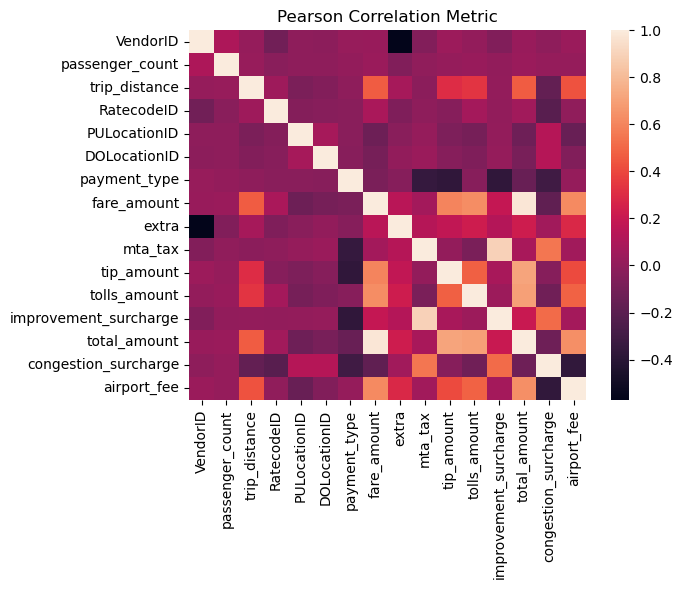

In [33]:
sns.heatmap(df.corr())
# wow that's easy...

plt.title('Pearson Correlation Metric')
plt.show()
# ... but is it really that easy? read below!

Things to take note of:
- `trip_distance` highly correlates with high tips, tolls and overall trip amount
- `payment_type` seems to have some form of negative correlation with `tip_amount`. **Be careful as this is a discrete category.**
- Having `VendorID`, `PULocationID`, `DOLocationID`, etc as features **is misleading**, why??? 

**Important:** Only include numerical and ordinal features when computing the Pearson Correlation metric. You cannot compute the correlation between a category and numerical feature (i.e `VendorID` vs `payment_type` vs `trip_distance`).

How about Locations? Does correlation work for it?

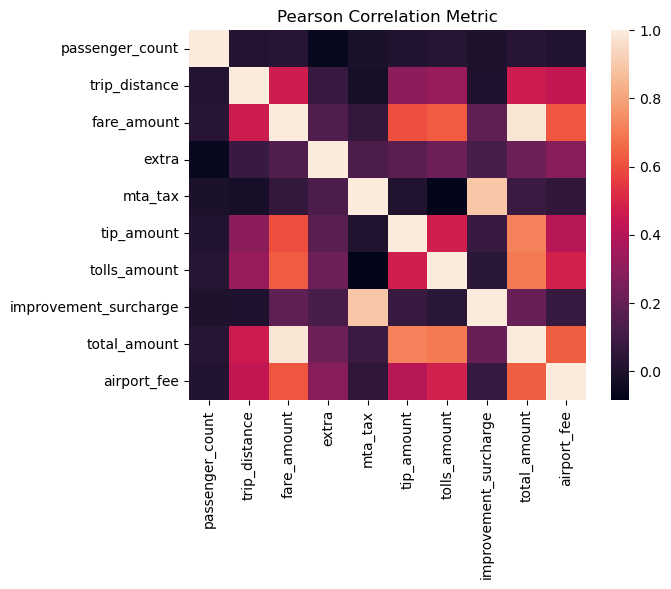

In [34]:
CORR_COLS = [
    "passenger_count", "trip_distance", "fare_amount", "extra", 
    "mta_tax", "tip_amount", "tolls_amount", "improvement_surcharge", 
    "total_amount", "airport_fee"
]

sns.heatmap(df[CORR_COLS].corr())

plt.title('Pearson Correlation Metric')
plt.show()

- If you're interested in calculating correlation between nominal and continuous data, here's a [great explanation](https://stats.stackexchange.com/questions/119835/correlation-between-a-nominal-iv-and-a-continuous-dv-variable/124618#124618).   
- Remember, you need to refer back to the data dictionary as well as the fare page: https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page

- You should especially take note of the fare page if you're looking to see how `RatecodeID` plays a role on the fare.

If you would like to use `pyspark` for the full dataset, you can compute the Pearson correlation between any two features. We don't expect students to use the full distribution for each field or use Spearman for nominal features, though, you are more than welcome to do so if you would like.

In [35]:
from pyspark.ml.stat import Correlation

sdf \
    .where(
        F.col('payment_type') == 1
    ) \
    .corr('trip_distance', 'tip_amount')

0.1285892987942448

We'll cover this in a bit more detail in the next tutorial, though, just be aware that `pyspark.ml` is out of scope for this subject due to time constraints.

`VectorAssembler` is a function used to merge multiple columns into a single vector column. This is required as Spark works for single vectors only. Just note that Spark's correlation is still a Work-In-Progress (WIP) so it can't handle `NULL` values. Make sure to drop or impute them (with justification) for your own project.

The process for this mirrors `sklearn` i.e `model.fit()` or `data.transform()` so this shouldn't be too unfamiliar.

In [36]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

features = "correlation_features"
assembler = VectorAssembler(
    inputCols=CORR_COLS, # input names (can be list of fields)
    outputCol=features # output name (single vector output)
)

# transform the features -> this is similar to sklearn's .fit() or .transform()
feature_vector = assembler \
                .transform(
                    sdf.dropna('any')
                ) \
                .select(features)

corr_matrix_dense = Correlation.corr(feature_vector, features)
corr_matrix_dense

23/07/24 14:06:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/07/24 14:06:00 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/Users/akiraw/miniconda3/envs/mast30034_env/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-----------------------------+
|pearson(correlation_features)|
+-----------------------------+
|         1.0              ...|
+-----------------------------+

As you can see in this intermediate step, we have a dense vector output. This is one exception where using `.collect()` is required. We'll grab the dense vector and create  a `pandas` dataframe. There's no need for `pyspark` since the results are computed already.

In [37]:
corr_matrix_dense.collect()

[Row(pearson(correlation_features)=DenseMatrix(10, 10, [1.0, 0.0039, 0.0332, -0.0565, -0.0041, 0.0125, 0.0252, 0.0039, ..., 0.5974, 0.3053, 0.0574, 0.4019, 0.4672, 0.0701, 0.6214, 1.0], False))]

In [38]:
corr_matrix = corr_matrix_dense.collect()[0][0].toArray().tolist()

df_corr = pd.DataFrame(corr_matrix, index=CORR_COLS, columns=CORR_COLS)

In [39]:
df_corr

passenger_count  trip_distance  fare_amount     extra  \
passenger_count               1.000000       0.003940     0.033165 -0.056511   
trip_distance                 0.003940       1.000000     0.119970  0.021894   
fare_amount                   0.033165       0.119970     1.000000  0.154254   
extra                        -0.056511       0.021894     0.154254  1.000000   
mta_tax                      -0.004062      -0.007549     0.056781  0.143025   
tip_amount                    0.012509       0.078229     0.588144  0.184981   
tolls_amount                  0.025171       0.086966     0.624357  0.225370   
improvement_surcharge         0.003885       0.000005     0.191962  0.136047   
total_amount                  0.031588       0.119829     0.979962  0.235495   
airport_fee                   0.016060       0.089564     0.597408  0.305270   

                        mta_tax  tip_amount  tolls_amount  \
passenger_count       -0.004062    0.012509      0.025171   
trip_distance         -0.007549    0.078229      0.086966   
fare_amount            0.056781    0.588144      0.624357   
extra                  0.143025    0.184981      0.225370   
mta_tax                1.000000    0.010371     -0.087943   
tip_amount             0.010371    1.000000      0.466650   
tolls_amount          -0.087943    0.466650      1.000000   
improvement_surcharge  0.883589    0.080617      0.044045   
total_amount           0.079162    0.709230      0.695038   
airport_fee            0.057378    0.401946      0.467250   

                       improvement_surcharge  total_amount  airport_fee  
passenger_count                     0.003885      0.031588     0.016060  
trip_distance                       0.000005      0.119829     0.089564  
fare_amount                         0.191962      0.979962     0.597408  
extra                               0.136047      0.235495     0.305270  
mta_tax                             0.883589      0.079162     0.057378  
tip_amount                          0.080617      0.709230     0.401946  
tolls_amount                        0.044045      0.695038     0.467250  
improvement_surcharge               1.000000      0.211383     0.070148  
total_amount                        0.211383      1.000000     0.621419  
airport_fee                         0.070148      0.621419     1.000000

Whilst the precision is excellent (and this is why using Spark is great over pandas), when presenting a report there should be at most 4 decimal places. 

We'll round it to 4 decimal places using a `pandas` option.

In [40]:
pd.options.display.float_format = '{:,.4f}'.format # any number of digits with 2 floating points

In [41]:
df_corr

passenger_count  trip_distance  fare_amount   extra  \
passenger_count                 1.0000         0.0039       0.0332 -0.0565   
trip_distance                   0.0039         1.0000       0.1200  0.0219   
fare_amount                     0.0332         0.1200       1.0000  0.1543   
extra                          -0.0565         0.0219       0.1543  1.0000   
mta_tax                        -0.0041        -0.0075       0.0568  0.1430   
tip_amount                      0.0125         0.0782       0.5881  0.1850   
tolls_amount                    0.0252         0.0870       0.6244  0.2254   
improvement_surcharge           0.0039         0.0000       0.1920  0.1360   
total_amount                    0.0316         0.1198       0.9800  0.2355   
airport_fee                     0.0161         0.0896       0.5974  0.3053   

                       mta_tax  tip_amount  tolls_amount  \
passenger_count        -0.0041      0.0125        0.0252   
trip_distance          -0.0075      0.0782        0.0870   
fare_amount             0.0568      0.5881        0.6244   
extra                   0.1430      0.1850        0.2254   
mta_tax                 1.0000      0.0104       -0.0879   
tip_amount              0.0104      1.0000        0.4666   
tolls_amount           -0.0879      0.4666        1.0000   
improvement_surcharge   0.8836      0.0806        0.0440   
total_amount            0.0792      0.7092        0.6950   
airport_fee             0.0574      0.4019        0.4672   

                       improvement_surcharge  total_amount  airport_fee  
passenger_count                       0.0039        0.0316       0.0161  
trip_distance                         0.0000        0.1198       0.0896  
fare_amount                           0.1920        0.9800       0.5974  
extra                                 0.1360        0.2355       0.3053  
mta_tax                               0.8836        0.0792       0.0574  
tip_amount                            0.0806        0.7092       0.4019  
tolls_amount                          0.0440        0.6950       0.4672  
improvement_surcharge                 1.0000        0.2114       0.0701  
total_amount                          0.2114        1.0000       0.6214  
airport_fee                           0.0701        0.6214       1.0000

We can compare the differences in correlation between the full distribution and 5% random sample.

What we do below **is not a valid comparison**. We are merely using it tell you that the LHS is not the same as the RHS.

In [42]:
df[CORR_COLS].corr()

passenger_count  trip_distance  fare_amount   extra  \
passenger_count                 1.0000         0.0192       0.0340 -0.0593   
trip_distance                   0.0192         1.0000       0.4625  0.0784   
fare_amount                     0.0340         0.4625       1.0000  0.1424   
extra                          -0.0593         0.0784       0.1424  1.0000   
mta_tax                        -0.0038        -0.0186       0.0626  0.1334   
tip_amount                      0.0140         0.3013       0.5997  0.1741   
tolls_amount                    0.0269         0.3329       0.6303  0.2234   
improvement_surcharge           0.0037         0.0086       0.1866  0.1258   
total_amount                    0.0326         0.4607       0.9809  0.2222   
airport_fee                     0.0142         0.4346       0.6162  0.2863   

                       mta_tax  tip_amount  tolls_amount  \
passenger_count        -0.0038      0.0140        0.0269   
trip_distance          -0.0186      0.3013        0.3329   
fare_amount             0.0626      0.5997        0.6303   
extra                   0.1334      0.1741        0.2234   
mta_tax                 1.0000      0.0113       -0.0837   
tip_amount              0.0113      1.0000        0.4735   
tolls_amount           -0.0837      0.4735        1.0000   
improvement_surcharge   0.8944      0.0811        0.0372   
total_amount            0.0844      0.7161        0.6985   
airport_fee             0.0558      0.4057        0.4809   

                       improvement_surcharge  total_amount  airport_fee  
passenger_count                       0.0037        0.0326       0.0142  
trip_distance                         0.0086        0.4607       0.4346  
fare_amount                           0.1866        0.9809       0.6162  
extra                                 0.1258        0.2222       0.2863  
mta_tax                               0.8944        0.0844       0.0558  
tip_amount                            0.0811        0.7161       0.4057  
tolls_amount                          0.0372        0.6985       0.4809  
improvement_surcharge                 1.0000        0.2060       0.0708  
total_amount                          0.2060        1.0000       0.6355  
airport_fee                           0.0708        0.6355       1.0000

In [43]:
abs(df_corr.abs() - df[CORR_COLS].corr().abs())

passenger_count  trip_distance  fare_amount  extra  \
passenger_count                 0.0000         0.0153       0.0008 0.0028   
trip_distance                   0.0153         0.0000       0.3425 0.0566   
fare_amount                     0.0008         0.3425       0.0000 0.0119   
extra                           0.0028         0.0566       0.0119 0.0000   
mta_tax                         0.0002         0.0110       0.0058 0.0096   
tip_amount                      0.0015         0.2231       0.0115 0.0109   
tolls_amount                    0.0017         0.2459       0.0059 0.0020   
improvement_surcharge           0.0002         0.0086       0.0054 0.0103   
total_amount                    0.0010         0.3408       0.0009 0.0133   
airport_fee                     0.0019         0.3450       0.0188 0.0190   

                       mta_tax  tip_amount  tolls_amount  \
passenger_count         0.0002      0.0015        0.0017   
trip_distance           0.0110      0.2231        0.2459   
fare_amount             0.0058      0.0115        0.0059   
extra                   0.0096      0.0109        0.0020   
mta_tax                 0.0000      0.0009        0.0043   
tip_amount              0.0009      0.0000        0.0069   
tolls_amount            0.0043      0.0069        0.0000   
improvement_surcharge   0.0108      0.0005        0.0068   
total_amount            0.0052      0.0069        0.0034   
airport_fee             0.0016      0.0038        0.0137   

                       improvement_surcharge  total_amount  airport_fee  
passenger_count                       0.0002        0.0010       0.0019  
trip_distance                         0.0086        0.3408       0.3450  
fare_amount                           0.0054        0.0009       0.0188  
extra                                 0.0103        0.0133       0.0190  
mta_tax                               0.0108        0.0052       0.0016  
tip_amount                            0.0005        0.0069       0.0038  
tolls_amount                          0.0068        0.0034       0.0137  
improvement_surcharge                 0.0000        0.0054       0.0006  
total_amount                          0.0054        0.0000       0.0141  
airport_fee                           0.0006        0.0141       0.0000

Look at this... there is a significant difference between `correlation(total_amount, tolls_amount)` between the two correlation matrices. **Be careful**. 

## Feature Engineering?
- We want to see if the the profitability of zones remains consistent with respect to hour of day, day of week and pickup location. The distribution of profitable zones should be similar across all years.

- How is a zone profitable? Frequency of trips? Duration of trips? Best "earners"? We've had creative metrics over the past few years that students invented. 

- For example, you could create your own feature and scale it accordingly. Perhaps the expected dollar per minute + possible tolls scaled by the expected frequency of trips might be a good start.

- Just remember that trip frequency $\approx$ taxi demand in a zone (you don't know the true number of taxis in a zone at the time).

- Additionally, variable rate fares exist: _"50 cents per 1/5 mile when travelling above 12mph OR 50 cents per 60 seconds in slow traffic or when the vehicle is stopped."_ 

- This means profit rates may require you to state the assumption that you are assuming constant velocity throughout the trip. We have had students in the past approximate this by finding speed limits of zones in NYC.